Linux
HOME -> /home/thompsong
Developer -> /home/thompsong/Developer
repodir -> /home/thompsong/Developer/KSCRocketSeismoHydrology/Python/new_workflow
work -> /home/thompsong/work
local_outdir -> /home/thompsong/work/PROJECTS/KSC_EROSION
DROPBOX_TOP -> /home/thompsong/Dropbox
new_data -> /data/KSC/EROSION/fromdropboxinventory
DROPBOX_DATA_TOP -> /home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA
dropbox_outdir -> /home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/new_workflow
WELLDATA_TOP -> /home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData
TOB3_DIR -> /home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/Uploads
transducersCSVfile -> /home/thompsong/Developer/KSCRocketSeismoHydrology/Python/new_workflo

/tmp/ipykernel_3867901/1997680642.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsub.dropna(how='all', axis=1, inplace=True)
/tmp/ipykernel_3867901/1997680642.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsub.dropna(how='all', axis=1, inplace=True)


      Unnamed: 0.1                TIMESTAMP    RECORD  uploaddate subdir  \
1                0  2022-07-21 13:47:50.000         0    20220826   20hz   
2                0  2022-07-21 13:47:50.000         0    20220826   20hz   
6                0  2022-07-21 16:00:00.050    158601    20220826   20hz   
8                0  2022-07-21 16:00:01.000      7931    20220826   20hz   
11               0  2022-07-21 20:00:00.050    446601    20220826   20hz   
...            ...                      ...       ...         ...    ...   
2260             0  2022-12-01 12:00:00.050  28764404    20221202   20hz   
2263             0  2022-12-01 16:00:00.050  29052404    20221202   20hz   
2266             0  2022-12-01 20:00:00.050  29340404    20221202   20hz   
2269             0  2022-12-02 00:00:00.050  29628404    20221202   20hz   
2272             0  2022-12-02 08:24:14.000  29786663    20221202   20hz   

                                      basename   Therm(1)   Therm(2)  \
1     20hz_Sens

KeyError: "None of [Index(['AirPressureShallow', 'AirPressureDeep'], dtype='object')] are in the [columns]"

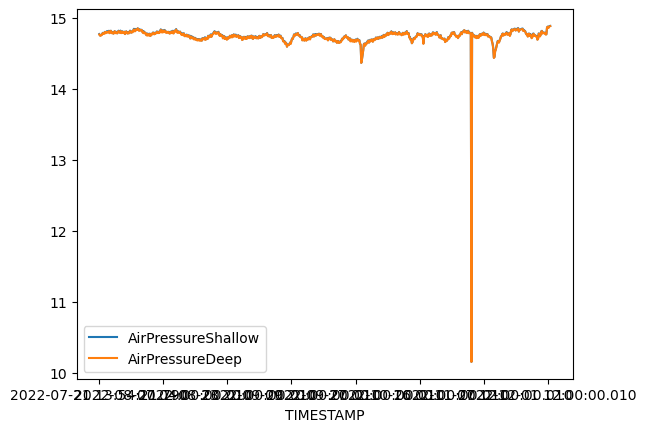

In [4]:
import header
paths = header.setup_environment()
for k,v in paths.items():
    print(k, '->', v)

import os
import pandas as pd

INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
dfall = pd.read_csv(os.path.join(INPUTDIR, 'all2.csv'))

for subdir in ['Baro', '20hz', '100hz']:
    dfsub = dfall[dfall['subdir']==subdir]
    dfsub.dropna(how='all', axis=1, inplace=True) 
    dfsub.drop(columns=['Unnamed: 0.1'])
    print(dfsub)
    dfsub.set_index('TIMESTAMP', inplace=True)
    dfsub.plot(y=['AirPressureShallow', 'AirPressureDeep'], kind='scatter;')